In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import random as rd
data = pd.read_csv("drive/My Drive/clean_tweet.csv",index_col=0)
data.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,tweet_text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [4]:
data[data.isnull().any(axis=1)].head(20)


,tweet_text,target
208,NaN,0
249,NaN,0
282,NaN,0
398,NaN,0
430,NaN,0
1011,NaN,0
1014,NaN,0
1231,NaN,0
1421,NaN,0
1486,NaN,0


In [5]:
data.dropna(inplace=True) #NAN values are coming from just @username, delete them 
data.reset_index(drop=True,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
tweet_text    1596041 non-null object
target        1596041 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [6]:
data[data.isnull().any(axis=1)].head(20)


,tweet_text,target


In [77]:
sample_data = data.sample(frac=(1/3), random_state=500)
sample_data

,tweet_text,target
611450,just checked weather hope it holds off raining...,0
110886,tiiiiiired made an idiot of myself in treasure...,0
139487,seriously hate my job so unhappy seriously hat...,0
859401,goddammit in trouble,4
530037,at pyramid brewery tonight unfortunately we re...,0
...,...,...
1143724,ah you,4
951904,just got back from great sleepover had bit too...,4
165355,my apple mouse does not work on my shiny red c...,0
1567246,first day of school today not that bad actuall...,4


In [0]:
x = sample_data.tweet_text
y = sample_data.target

In [79]:
len(x)
len(y)

532014

In [0]:
from tqdm import tqdm
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [0]:

all_x = pd.concat([x])
all_x_w2v = labelize_tweets_ug(all_x, 'all')


In [40]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])


100%|██████████| 100551/100551 [00:00<00:00, 1952958.84it/s]


In [41]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 100551/100551 [00:00<00:00, 2405840.66it/s]


CPU times: user 1min 28s, sys: 615 ms, total: 1min 29s
Wall time: 49.5 s


In [42]:
model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 100551/100551 [00:00<00:00, 2262233.80it/s]


In [43]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 100551/100551 [00:00<00:00, 2433268.88it/s]


CPU times: user 2min 28s, sys: 609 ms, total: 2min 28s
Wall time: 1min 19s


In [44]:
model_ug_cbow.save('drive/My Drive/rnn2_w2v_model_ug_cbow.word2vec') #rnn2 = 100551, rnn = frac =1/3
model_ug_sg.save('drive/My Drive/rnn2_w2v_model_ug_sg.word2vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [80]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('drive/My Drive/rnn_w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('drive/My Drive/rnn_w2v_model_ug_sg.word2vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [81]:
len(model_ug_cbow.wv.vocab.keys())


56319

In [82]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 56319 word vectors.


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x)

X_train = tokenizer.texts_to_sequences(x)

In [84]:
X_train = pad_sequences(X_train, maxlen=50)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (532014, 50)


In [0]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [86]:
y

611450     0
110886     0
139487     0
859401     4
530037     0
          ..
1143724    4
951904     4
165355     0
1567246    4
1311314    4
Name: target, Length: 532014, dtype: int64

In [0]:

#1 == positive, 0 == negative
y = np.array(list(map(lambda x: 0 if x==0 else 1, y)))

In [0]:
y_train = y

In [89]:
y_train

array([0, 0, 0, ..., 0, 1, 1])

In [0]:
#RNN (LSTM) Structure 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model
from keras.layers.recurrent import LSTM

def get_model3():

  model3 = Sequential()
  embedding_layer = Embedding(100000, 200, weights=[embedding_matrix], input_length=50 , trainable=False)
  model3.add(embedding_layer)
  model3.add(LSTM(128))

  model3.add(Dense(1, activation='sigmoid'))
  model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


  return model3

In [91]:
from keras.callbacks import ModelCheckpoint

filepath="drive/My Drive/CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint3 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model_4 = get_model3()

history3 = model_4.fit(X_train, y_train, batch_size=32, epochs=4, validation_split=0.15, callbacks = [checkpoint3])

Train on 452211 samples, validate on 79803 samples
Epoch 1/4
452211/452211 [==============================] - 1838s 4ms/step - loss: 0.4192 - acc: 0.8066 - val_loss: 0.3963 - val_acc: 0.8192

Epoch 00001: val_acc improved from -inf to 0.81915, saving model to drive/My Drive/CNN_best_weights.01-0.8192.hdf5
Epoch 2/4
452211/452211 [==============================] - 1813s 4ms/step - loss: 0.3808 - acc: 0.8282 - val_loss: 0.3887 - val_acc: 0.8245

Epoch 00002: val_acc improved from 0.81915 to 0.82451, saving model to drive/My Drive/CNN_best_weights.02-0.8245.hdf5
Epoch 3/4
452211/452211 [==============================] - 1836s 4ms/step - loss: 0.3607 - acc: 0.8388 - val_loss: 0.3905 - val_acc: 0.8249

Epoch 00003: val_acc improved from 0.82451 to 0.82491, saving model to drive/My Drive/CNN_best_weights.03-0.8249.hdf5
Epoch 4/4
452211/452211 [==============================] - 1868s 4ms/step - loss: 0.3432 - acc: 0.8480 - val_loss: 0.3952 - val_acc: 0.8232

Epoch 00004: val_acc did not impro

In [92]:
columns = ['polarity','tweet_id','date','query_string','username','tweet_text']

test = pd.read_csv("drive/My Drive/testdata.csv", sep=",", header = None, names=columns)
test

,polarity,tweet_id,date,query_string,username,tweet_text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
...,...,...,...,...,...,...
493,2,14072,Sun Jun 14 04:31:43 UTC 2009,latex,proggit,Ask Programming: LaTeX or InDesign?: submitted...
494,0,14073,Sun Jun 14 04:32:17 UTC 2009,latex,sam33r,"On that note, I hate Word. I hate Pages. I hat..."
495,4,14074,Sun Jun 14 04:36:34 UTC 2009,latex,iamtheonlyjosie,Ahhh... back in a *real* text editing environm...
496,0,14075,Sun Jun 14 21:36:07 UTC 2009,iran,plutopup7,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [93]:
test.polarity.value_counts() #80,000 positive and negative examples 


4    182
0    177
2    139
Name: polarity, dtype: int64

In [0]:
test = test[test.polarity != 2] #Drop neutral rows for binary classification (postive or negative)


In [95]:
x_test = test['tweet_text']
x_test

0      @stellargirl I loooooooovvvvvveee my Kindle2. ...
1      Reading my kindle2...  Love it... Lee childs i...
2      Ok, first assesment of the #kindle2 ...it fuck...
3      @kenburbary You'll love your Kindle2. I've had...
4      @mikefish  Fair enough. But i have the Kindle2...
                             ...                        
492    After using LaTeX a lot, any other typeset mat...
494    On that note, I hate Word. I hate Pages. I hat...
495    Ahhh... back in a *real* text editing environm...
496    Trouble in Iran, I see. Hmm. Iran. Iran so far...
497    Reading the tweets coming out of Iran... The w...
Name: tweet_text, Length: 359, dtype: object

In [96]:
y_test = test['polarity']
y_test

0      4
1      4
2      4
3      4
4      4
      ..
492    4
494    0
495    4
496    0
497    0
Name: polarity, Length: 359, dtype: int64

In [0]:
X_test = []
tweets = list(test['tweet_text'])
for lines in tweets:
    X_test.append(lines)

y_test = test['polarity']

#1 == positive, 0 == negative
y_test = np.array(list(map(lambda x: 0 if x==0 else 1, y_test))) 

In [0]:
sequences_test = tokenizer.texts_to_sequences(X_test)
x_test_seq = pad_sequences(sequences_test, maxlen=50)

In [99]:
from keras.models import load_model
loaded_CNN_model = load_model('drive/My Drive/CNN_best_weights.03-0.8249.hdf5')
score = loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

359/359 [==============================] - 2s 6ms/step


In [100]:
score[0]

0.41496139997227277

In [101]:
score[1]

0.8133704737036341

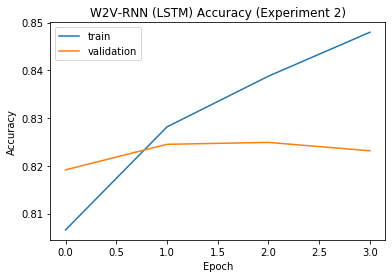

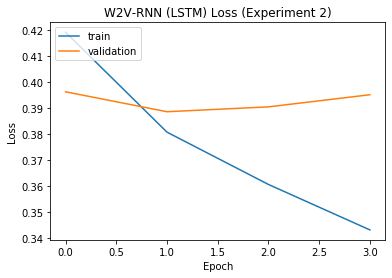

In [103]:
#Graphs

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])

plt.title('W2V-RNN (LSTM) Accuracy (Experiment 2)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])

plt.title('W2V-RNN (LSTM) Loss (Experiment 2)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()